In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from ta import *
import cse491H.load as load
import cse491H.preproc as preproc
import tensorflow as tf
from tensorflow import keras
from copy import deepcopy 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 3000)

In [2]:
# load the data
df = load.load_basic()
df = preproc.shifted_price_col(df,'NextClose',-1)
df.head().values

array([[Timestamp('2017-10-02 00:00:00'), 22423.470703, 22559.380859,
        22416.0, 22557.599609, 268530000, 22641.669922],
       [Timestamp('2017-10-03 00:00:00'), 22564.449219, 22646.320313,
        22562.900391, 22641.669922, 238830000, 22661.640625],
       [Timestamp('2017-10-04 00:00:00'), 22645.669922, 22685.939453,
        22632.800781, 22661.640625, 235730000, 22775.390625],
       [Timestamp('2017-10-05 00:00:00'), 22669.080078, 22777.039063,
        22655.140625, 22775.390625, 246400000, 22773.669922],
       [Timestamp('2017-10-06 00:00:00'), 22762.029297, 22773.669922,
        22730.849609, 22773.669922, 221450000, 22761.070313]],
      dtype=object)

In [3]:
train, test = preproc.train_test(df)

In [4]:
# normalize 
train = train.drop("Date",axis=1)
test = test.drop("Date",axis=1)

scaler, train_scaled, test_scaled = preproc.scale(train,test)

train_scaled.head()

/Users/paulsoma/anaconda3/envs/cse491H/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Open,High,Low,Close,Volume,NextClose
63,0.394249,0.331242,0.452042,0.418617,0.271758,0.450616
64,0.408275,0.360904,0.479171,0.450616,0.446213,0.500057
65,0.447321,0.423501,0.523728,0.500057,0.365501,0.571644
66,0.498534,0.497466,0.571852,0.571644,0.297234,0.567470
67,0.564566,0.502122,0.611776,0.567470,0.272150,0.600809


In [5]:
X_train = train_scaled.drop('NextClose', axis=1)
y_train = train_scaled['NextClose']

X_test = test_scaled.drop('NextClose', axis=1)
y_test = test_scaled['NextClose']

print(X_train.head())
print('\n')
print(y_train.head())

        Open      High       Low     Close    Volume
63  0.394249  0.331242  0.452042  0.418617  0.271758
64  0.408275  0.360904  0.479171  0.450616  0.446213
65  0.447321  0.423501  0.523728  0.500057  0.365501
66  0.498534  0.497466  0.571852  0.571644  0.297234
67  0.564566  0.502122  0.611776  0.567470  0.272150


63    0.450616
64    0.500057
65    0.571644
66    0.567470
67    0.600809
Name: NextClose, dtype: float64


In [24]:
def plot_history(history, metric, figname=None):
    
    plt.figure()
    
    train_mae = np.array(history.history[metric])
    val_mae = np.array(history.history['val_' + metric])
    
    
    train_label = 'Training '
    val_label = 'Validation '
    
    plt.plot(history.epoch, train_mae,
           label=train_label)
    plt.plot(history.epoch, val_mae,
           label = val_label)
    
    ymin = np.min([np.min(train_mae), np.min(val_mae), 0])
    ymax = np.max([np.max(train_mae), np.max(val_mae)])
   
    plt.ylim([ymin, ymax])
    
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    plt.legend()
    
    if figname is not None:
        plt.savefig(figname)


def construct_model_1(input_shape):

    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                           input_shape=(input_shape,)),
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    optimizer = tf.train.AdamOptimizer(0.001)

    model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

def construct_model_2(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.relu,
                           input_shape=(input_shape,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(8, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.train.AdamOptimizer(0.001)
    
    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mse','mae'])
    return model





....................

....................

.................

....................

....................

...
................

...............

..................

..................

.................

................


.................

..........

.................

.................

..................

.................

....
...............

..................

...................

....................

..................

..........
...

......

.......

......

...............

..................

..................

....................

.......
..............

.................

.................

...................

...................

..............
.....

..................

....................

....................

....................

.................
...

......

.........

...................

.....................

....................

....................

..
..............

.................

....................

...................

..................

............
.......

.................

....................

....................

..................

..................

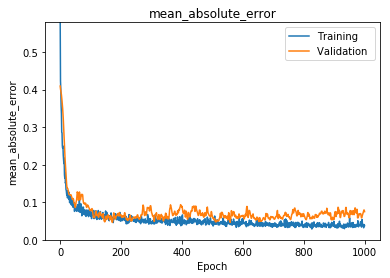

In [7]:
model2 = construct_model_2(X_train.shape[1])

EPOCHS = 1000

# callbacks
class PrintPct(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


history2 = model2.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintPct()])

plot_history(history2,'mean_absolute_error','model_2_mean_absolute_error')

In [8]:
#plot_history(history2,'mean_absolute_error','Regression Mean Absolute Error')

metric_keys2 = model2.metrics_names
test_metric_vals2 = model2.evaluate(X_test, y_test, verbose=0)

test_metrics2 = dict(zip(metric_keys2, test_metric_vals2))
y_test_pred2 = model2.predict(X_test)

In [9]:
# recombine test X and y to rescale with same scaler

Xy_test2 = deepcopy(X_test)
Xy_test2['NextClose'] = y_test_pred2
Xy_test2.head()

,Open,High,Low,Close,Volume,NextClose
209,0.616860,0.569592,0.625659,0.583951,0.233672,0.607365
210,0.546836,0.520625,0.574459,0.581467,0.221334,0.673039
211,0.582302,0.561616,0.640817,0.625709,0.117741,0.649849
212,0.608601,0.589137,0.659003,0.638551,0.117696,0.636361
213,0.647582,0.647407,0.714092,0.679651,0.119084,0.613763


In [10]:
# rescaled X_test
test_resc2 = scaler.inverse_transform(Xy_test2)

cols = test.columns

test_resc2 = pd.DataFrame(test_resc2, columns=cols, index=Xy_test2.index)

usd_err2 = np.abs(test.NextClose - test_resc2.NextClose)
np.sum(usd_err2)

7439.950314567432

In [11]:
def plot_prediction(actual, predicted, figname=None):
    """
    
    :param actual: actual next day closing price in USD
    :param predicted: predicted next day closing price in USd
    :return: 
    """
    plt.figure()
    
    plt.title('')
    
    xvals = range(actual.shape[0])
    
    plt.plot(xvals, actual,
           label='Actual')
    plt.plot(xvals, predicted,
           label = 'Predicted')
    
    ymin = np.min([np.min(actual), np.min(predicted)]) - 500
    ymax = np.max([np.max(actual), np.max(predicted)]) + 500
   
    plt.ylim([ymin, ymax])
    
    plt.title('Closing Price')
    plt.xlabel('t')
    plt.ylabel('$USD')
    
    plt.legend()
    
    if figname is not None:
        plt.savefig(figname)
    

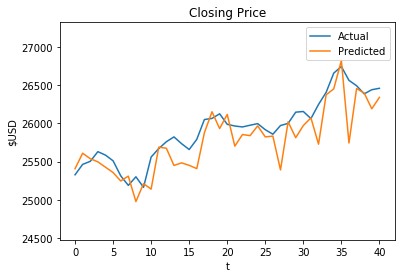

In [13]:
plot_prediction(test.NextClose, test_resc2.NextClose, 
                figname='regression_closing_price')


................................

.........................

.............

..........

.................

...
................

................

.....................

.......................

.......................

.
.....................

................

..............

................

......................

...........
...........

.......................

............................

...........................

...........
................

........................

.............................

..............................

.
..............................

........................

.............................

.................
..............

............................

............................

........................

......
...................

...........................

.............................

.........

................
...........

........................

.............................

..............................

......
.......................

.....................

...............................

.........................

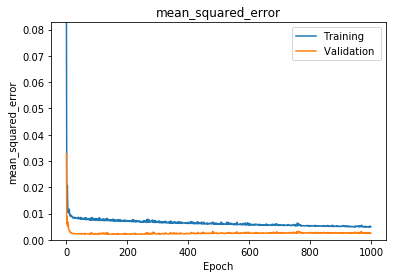

In [25]:
model1 = construct_model_1(X_train.shape[1])

EPOCHS = 1000

# callbacks
class PrintPct(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


history1 = model1.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintPct()])

plot_history(history1,'mean_squared_error','model_1_error_batch_norm')

In [26]:
metric_keys1 = model1.metrics_names
test_metric_vals1 = model1.evaluate(X_test, y_test, verbose=0)

test_metrics1 = dict(zip(metric_keys1, test_metric_vals1))
y_test_pred1 = model1.predict(X_test)

In [27]:
# rescaled X_test
Xy_test1 = deepcopy(X_test)
Xy_test1['NextClose'] = y_test_pred1
Xy_test1.head()


test_resc1 = scaler.inverse_transform(Xy_test1)

cols = test.columns

test_resc1 = pd.DataFrame(test_resc1, columns=cols, index=Xy_test1.index)

usd_err1 = np.abs(test.NextClose - test_resc1.NextClose)
np.sum(usd_err1)

11461.635010397858

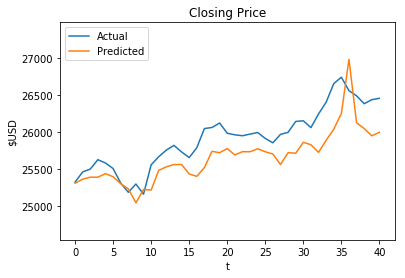

In [38]:
plot_prediction(test.NextClose, test_resc1.NextClose, 
                figname='model_1_pred')

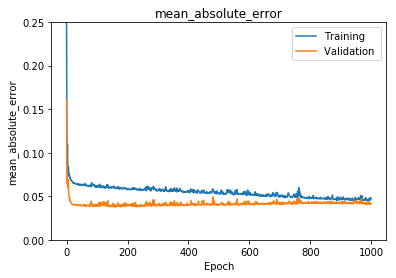

In [36]:
plot_history(history1,'mean_absolute_error','model_1_mae')

In [43]:
Xy_test1

,Open,High,Low,Close,Volume,NextClose
209,0.616860,0.569592,0.625659,0.583951,0.233672,0.576248
210,0.546836,0.520625,0.574459,0.581467,0.221334,0.594072
211,0.582302,0.561616,0.640817,0.625709,0.117741,0.603005
212,0.608601,0.589137,0.659003,0.638551,0.117696,0.602783
213,0.647582,0.647407,0.714092,0.679651,0.119084,0.618370
214,0.669448,0.625041,0.715979,0.665005,0.085689,0.604979
215,0.660598,0.617105,0.695016,0.640838,0.081466,0.574441
216,0.596233,0.536160,0.607723,0.577245,0.110893,0.551701
217,0.570978,0.528605,0.585414,0.536564,0.089037,0.490539
218,0.532925,0.512623,0.600924,0.572957,0.087861,0.548985


In [45]:
np.sum(usd_err1) / usd_err1.shape[0]

279.552073424338

In [46]:
np.sum(usd_err2) / usd_err2.shape[0]

181.4622027943276